In [1]:
# If the code is executed from Google Drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/TFM_Generacion_electrica_AEMET/Python                                                                         

Mounted at /content/drive
/content/drive/My Drive/TFM_Generacion_electrica_AEMET/Python


In [2]:
# Instalacion libreria AEMET para ingesta de datos
!pip install python-aemet

     |████████████████████████████████| 409kB 6.3MB/s 


In [3]:
from Lectura_AEMET_REE import Ingestion_AEMET,Ingestion_REE
from sklearn.metrics import mean_absolute_error,mean_squared_error
from utils import date_transform,evaluation_function,plot_metrics,plot_real_vs_pred,train_test_val_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.options.display.max_columns=None
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
sns.set_palette("Set2")
sns.set_style("ticks")

Ing_AEMET=Ingestion_AEMET()



#2- Reading DataFrames from pickle

In [4]:
df_weather_system=pd.read_pickle(Ing_AEMET.path_Data+"Wheater_featuring.pkl")

In [5]:
df_weather_system.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9875 entries, 0 to 9874
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     9875 non-null   object 
 1   system    9875 non-null   object 
 2   Holiday   9875 non-null   int64  
 3   weekday   9875 non-null   object 
 4   tmin      9875 non-null   float64
 5   presMin   9875 non-null   float64
 6   prec      9875 non-null   float64
 7   tmed      9875 non-null   float64
 8   sol       9875 non-null   float64
 9   velmedia  9875 non-null   float64
 10  tmax      9875 non-null   float64
 11  presMax   9875 non-null   float64
 12  racha     9875 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.1+ MB


In [6]:
df_ree_target=pd.read_pickle(Ing_AEMET.path_Data+"ree_target.pkl")

In [7]:
df_ree_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7496 entries, 0 to 7495
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   x1_baleares                7496 non-null   float64
 1   x1_canarias                7496 non-null   float64
 2   x1_melilla                 7496 non-null   float64
 3   x1_peninsular              7496 non-null   float64
 4   fecha                      7496 non-null   object 
 5   Generacion_Mwh             7496 non-null   float64
 6   x0_Carbón                  7496 non-null   float64
 7   x0_Ciclo combinado         7496 non-null   float64
 8   x0_Cogeneración            7496 non-null   float64
 9   x0_Eólica                  7496 non-null   float64
 10  x0_Fuel + Gas              7496 non-null   float64
 11  x0_Hidroeólica             7496 non-null   float64
 12  x0_Hidráulica              7496 non-null   float64
 13  x0_Motores diésel          7496 non-null   float

##3- Featuring

In [8]:
from sklearn.preprocessing import OneHotEncoder

enc_system=OneHotEncoder().fit(df_weather_system[['system']])

df_transform_weather=enc_system.transform(df_weather_system[['system']])

column_weather=enc_system.get_feature_names(['x1'])

df_onehot_weather = pd.DataFrame(df_transform_weather.todense(),columns=column_weather)

     
df_weather_features=pd.merge(df_weather_system,df_onehot_weather,left_index=True,right_index=True)                               
df_weather_features.drop('system',axis=1,inplace=True)
                               

In [9]:
df_weather_features.head()

,fecha,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,2016-01-01,1,4,3.300000,1009.300000,0.022222,13.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,1.0,0.0,0.0,0.0,0.0
1,2016-01-01,1,4,7.900000,894.700000,0.000000,18.040000,9.266667,2.781667,24.250000,1025.450000,10.400000,0.0,1.0,0.0,0.0,0.0
2,2016-01-01,1,4,13.800000,1012.400000,0.000000,17.500000,7.600000,1.400000,21.200000,1015.400000,10.800000,0.0,0.0,1.0,0.0,0.0
3,2016-01-01,1,4,10.600000,1016.600000,0.000000,15.500000,9.100000,1.700000,20.400000,1019.900000,5.600000,0.0,0.0,0.0,1.0,0.0
4,2016-01-01,1,4,3.817021,921.165957,5.477102,10.207533,2.231907,3.189763,16.440426,984.380851,16.361702,0.0,0.0,0.0,0.0,1.0


In [10]:
df_ree_target.head()

,x1_baleares,x1_canarias,x1_melilla,x1_peninsular,fecha,Generacion_Mwh,x0_Carbón,x0_Ciclo combinado,x0_Cogeneración,x0_Eólica,x0_Fuel + Gas,x0_Hidroeólica,x0_Hidráulica,x0_Motores diésel,x0_Nuclear,x0_Otras renovables,x0_Residuos no renovables,x0_Residuos renovables,x0_Solar fotovoltaica,x0_Solar térmica,x0_Turbina de gas,x0_Turbina de vapor,x0_Turbinación bombeo,x2_No-Renovable,x2_Renovable
0,0.0,0.0,0.0,1.0,2016-01-01,537090.081,24401.321,48452.794,41918.271,199437.416,0.0,0.0,29281.000,0.0,162745.220,7169.124,3848.0700,1179.2320,8179.808,695.552,0.0,0.0,9782.273,0.542084,0.457916
1,0.0,0.0,0.0,1.0,2016-01-02,619096.702,28801.603,46225.570,53159.017,235393.376,0.0,0.0,35544.881,0.0,169614.296,7847.535,4097.2255,1139.0335,11752.604,1260.093,0.0,0.0,24261.468,0.526831,0.473169
2,0.0,0.0,0.0,1.0,2016-01-03,663175.263,23566.714,41437.666,55732.000,310829.594,0.0,0.0,35910.705,0.0,164994.879,7537.867,5092.0860,1186.0190,4289.693,95.938,0.0,0.0,12502.102,0.457384,0.542616
3,0.0,0.0,0.0,1.0,2016-01-04,670891.594,38141.154,48699.226,64779.758,258293.301,0.0,0.0,65268.886,0.0,145859.298,7923.656,5459.3545,1664.4695,4248.155,69.916,0.0,0.0,30484.420,0.496985,0.503015
4,0.0,0.0,0.0,1.0,2016-01-05,712002.286,40585.072,38793.648,66654.856,290391.365,0.0,0.0,79718.832,0.0,146050.955,7911.694,5786.8765,1973.6505,11973.133,1432.872,0.0,0.0,20729.332,0.447472,0.552528


##  Tratamiento de fechas

Para pasar las fechas aun formato en que el salto entre el ultimo dia de un mes y el primer dia del siguiente sea continuo, uso los cosenos de los dias y meses. 

Para ello situo los valores de los 31 dias en angulos iguales calulandolos como $Dia(x)=\cos\frac{2\pi}{31}x$

Para los meses situo cada mes en $Mes(x)=\cos\frac{2\pi}{12}x$

Y para los dias de la semana $Weekday(x)=\cos\frac{2\pi}{7}x$

In [11]:
df_weather_procesed=date_transform(df_weather_features);
df_weather_procesed.head()

,fecha,Holiday,weekday,tmin,presMin,prec,tmed,sol,velmedia,tmax,presMax,racha,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular,year,day,month
0,2016-01-01,1,-0.900969,3.300000,1009.300000,0.022222,13.022222,1.940000,2.366667,18.900000,1024.900000,14.200000,1.0,0.0,0.0,0.0,0.0,7.608871,0.97953,0.866025
1,2016-01-01,1,-0.900969,7.900000,894.700000,0.000000,18.040000,9.266667,2.781667,24.250000,1025.450000,10.400000,0.0,1.0,0.0,0.0,0.0,7.608871,0.97953,0.866025
2,2016-01-01,1,-0.900969,13.800000,1012.400000,0.000000,17.500000,7.600000,1.400000,21.200000,1015.400000,10.800000,0.0,0.0,1.0,0.0,0.0,7.608871,0.97953,0.866025
3,2016-01-01,1,-0.900969,10.600000,1016.600000,0.000000,15.500000,9.100000,1.700000,20.400000,1019.900000,5.600000,0.0,0.0,0.0,1.0,0.0,7.608871,0.97953,0.866025
4,2016-01-01,1,-0.900969,3.817021,921.165957,5.477102,10.207533,2.231907,3.189763,16.440426,984.380851,16.361702,0.0,0.0,0.0,0.0,1.0,7.608871,0.97953,0.866025


## Unir las 2 tablas  df_weather_features, df_ree_target
To get only the features and targets of the same dates and systems

In [12]:
df_weather_ree=pd.merge(df_weather_procesed,
                            df_ree_target, 
                             on=['fecha','x1_baleares','x1_canarias','x1_melilla','x1_peninsular'])

# Models for Total Generation

In [13]:
features_list=['Holiday','weekday','tmin','presMin','prec','sol','tmax','presMax','racha','velmedia','year','day','month','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']
target_list=['Generacion_Mwh','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']

##Train-Test split

In [14]:
X_train,X_test,y_train,y_test,X_validation,y_validacion=train_test_val_split(df_weather_ree,
                                                                        features_list,
                                                                        target_list,
                                                                        .1,
                                                                        0)

##Scaler

In [15]:
from sklearn.preprocessing import StandardScaler

cols_scaler=['tmin','presMin','prec','sol','tmax','presMax','racha','velmedia']
scaler=StandardScaler().fit(X_train[cols_scaler])

X_train[cols_scaler]=scaler.transform(X_train[cols_scaler])
X_test[cols_scaler]=scaler.transform(X_test[cols_scaler])
X_train.head()

,Holiday,weekday,tmin,presMin,prec,sol,tmax,presMax,racha,velmedia,year,day,month,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,1,-0.900969,-1.136261,1.001632,-0.299348,-1.860133,-0.912298,0.989529,0.086529,-0.813986,7.608871,0.979530,0.866025,1.0,0.0,0.0,0.0,0.0
1,1,-0.900969,-0.427684,-1.208123,-0.305329,0.460875,-0.026751,1.022056,-0.660018,-0.508034,7.608871,0.979530,0.866025,0.0,1.0,0.0,0.0,0.0
2,1,-0.900969,-0.011780,1.142394,-0.305329,0.408077,-0.664014,0.693821,-1.603026,-1.305476,7.608871,0.979530,0.866025,0.0,0.0,0.0,1.0,0.0
3,1,-0.900969,-1.056619,-0.697798,1.168923,-1.767660,-1.319413,-1.406834,0.511217,-0.207171,7.608871,0.979530,0.866025,0.0,0.0,0.0,0.0,1.0
4,0,-0.222521,-1.043838,0.945714,-0.305329,-1.479986,-0.614357,0.770705,1.874314,0.750589,7.608871,0.918958,0.866025,1.0,0.0,0.0,0.0,0.0


In [16]:
X_train

,Holiday,weekday,tmin,presMin,prec,sol,tmax,presMax,racha,velmedia,year,day,month,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,1,-0.900969,-1.136261,1.001632,-0.299348,-1.860133,-0.912298,0.989529,0.086529,-0.813986,7.608871,0.979530,0.866025,1.0,0.0,0.0,0.0,0.0
1,1,-0.900969,-0.427684,-1.208123,-0.305329,0.460875,-0.026751,1.022056,-0.660018,-0.508034,7.608871,0.979530,0.866025,0.0,1.0,0.0,0.0,0.0
2,1,-0.900969,-0.011780,1.142394,-0.305329,0.408077,-0.664014,0.693821,-1.603026,-1.305476,7.608871,0.979530,0.866025,0.0,0.0,0.0,1.0,0.0
3,1,-0.900969,-1.056619,-0.697798,1.168923,-1.767660,-1.319413,-1.406834,0.511217,-0.207171,7.608871,0.979530,0.866025,0.0,0.0,0.0,0.0,1.0
4,0,-0.222521,-1.043838,0.945714,-0.305329,-1.479986,-0.614357,0.770705,1.874314,0.750589,7.608871,0.918958,0.866025,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,0,-0.222521,-1.465313,-0.412296,-0.303993,0.086247,-1.051055,-1.123458,-0.928792,-1.107149,7.610853,-0.440394,0.866025,0.0,0.0,0.0,0.0,1.0
6728,0,0.623490,-1.197876,1.113470,-0.305329,-0.146304,-0.879193,1.172867,0.184759,0.110015,7.610853,-0.250653,0.866025,1.0,0.0,0.0,0.0,0.0
6729,0,0.623490,-0.050290,-1.258257,-0.305329,-0.006389,0.544303,0.702692,0.243697,0.062504,7.610853,-0.250653,0.866025,0.0,1.0,0.0,0.0,0.0
6730,0,0.623490,0.234681,1.198312,-0.305329,0.408077,-0.862641,0.835761,-0.797540,-0.494518,7.610853,-0.250653,0.866025,0.0,0.0,0.0,1.0,0.0


##Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression


reg_ln=LinearRegression()

reg_ln.fit(X_train,y_train['Generacion_Mwh'])

y_pred_ln=reg_ln.predict(X_test)


##K-Neighbors

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

reg_KN=GridSearchCV(KNeighborsRegressor(),param_grid={"n_neighbors":np.arange(3,100)},scoring='neg_mean_squared_error')
reg_KN.fit(X_train,y_train['Generacion_Mwh'])
y_pred_KN=reg_KN.predict(X_test)
reg_KN.best_params_

{'n_neighbors': 16}

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeRegressor

params_DT={'max_depth':range(3,10),'min_samples_leaf':range(1,5)}

reg_DT=GridSearchCV(DecisionTreeRegressor(random_state=7),param_grid=params_DT,scoring='neg_mean_squared_error')
reg_DT.fit(X_train,y_train['Generacion_Mwh'])
y_pred_DT=reg_DT.predict(X_test)
reg_DT.best_params_

{'max_depth': 5, 'min_samples_leaf': 2}

##Boosting Models


###XGBoost

In [20]:
from xgboost import XGBRegressor,DMatrix

params_xgb={
    'max_depth':range(3,8),
    'n_estimators':range(60,80,1),
    'learning_rate':np.arange(.1,.14,.005),
    'subsample':np.arange(.4,0.6,0.05)
    }

reg_XGB=GridSearchCV(XGBRegressor(objective='reg:squarederror',random_state=7),param_grid=params_xgb,scoring='neg_mean_squared_error')

reg_XGB.fit(X_train,y_train['Generacion_Mwh'])
y_pred_XGB=reg_XGB.predict(X_test)

print(reg_XGB.best_params_)
print(reg_XGB.best_estimator_)
print(reg_XGB.best_score_)

{'learning_rate': 0.12500000000000003, 'max_depth': 5, 'n_estimators': 61, 'subsample': 0.5}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.12500000000000003,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=61, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=7, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.5, verbosity=1)
-947529631.5777794


###LightGBM

In [21]:
from lightgbm import LGBMRegressor

params_LGBM={
    'max_depth':range(3,8),
    'n_estimators':range(110,130,1),
    'learning_rate':np.arange(.09,.13,.005),
    'subsample':np.arange(.3,0.6,0.05)
    }

reg_LGBM=GridSearchCV(LGBMRegressor(random_state=7),param_grid=params_LGBM,scoring='neg_mean_squared_error')

reg_LGBM.fit(X_train,y_train['Generacion_Mwh'])
y_pred_LGBM=reg_LGBM.predict(X_test)

print(reg_LGBM.best_params_)
print(reg_LGBM.best_estimator_)
print(reg_LGBM.best_score_)

{'learning_rate': 0.095, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.3}
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.095, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=114, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.3, subsample_for_bin=200000, subsample_freq=0)
-825340022.2677813


# Evaluation for Total Generation


## Model choice

,Model_name,MAE,RMSE
0,LinearRegresion (Base Model),19339.859361,41208.403990
0,KNeighbors,12017.578343,35419.074221
0,DecissionTree,15008.542756,35627.859068
0,XGBoost,13025.300006,33601.362722
0,LightGBM,11940.018021,33342.062263


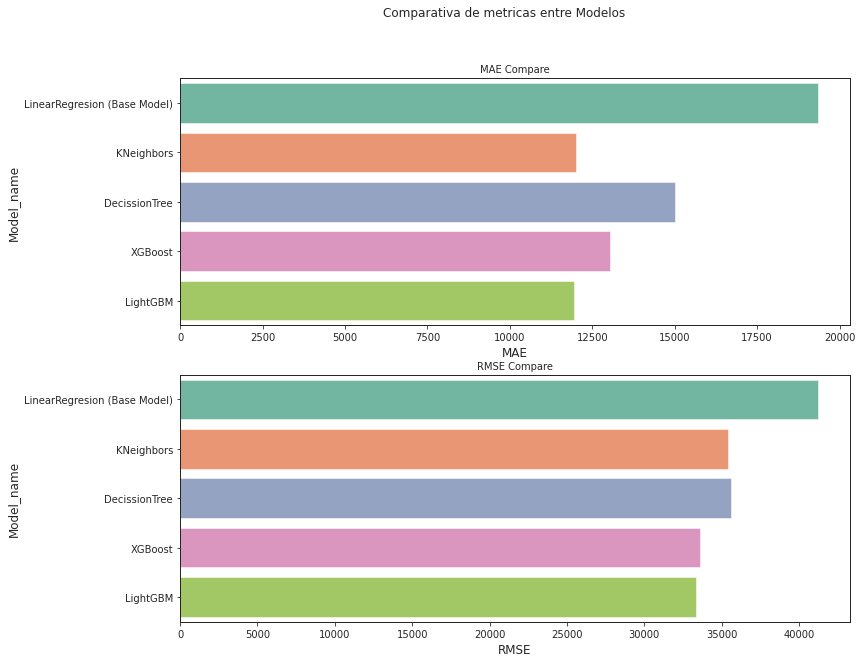

In [22]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

pd_ln=evaluation_function(y_test['Generacion_Mwh'],y_pred_ln,'LinearRegresion (Base Model)')
pd_kn=evaluation_function(y_test['Generacion_Mwh'],y_pred_KN,'KNeighbors')
pd_DT=evaluation_function(y_test['Generacion_Mwh'],y_pred_DT,'DecissionTree')
pd_XGB=evaluation_function(y_test['Generacion_Mwh'],y_pred_XGB,'XGBoost')
pd_LGBM=evaluation_function(y_test['Generacion_Mwh'],y_pred_LGBM,'LightGBM')

pd_metrics=pd_ln.append(pd_kn)
pd_metrics=pd_metrics.append(pd_DT)
pd_metrics=pd_metrics.append(pd_XGB)
pd_metrics=pd_metrics.append(pd_LGBM)

plot_metrics(pd_metrics)

pd_metrics

## Real vs prediction comparation

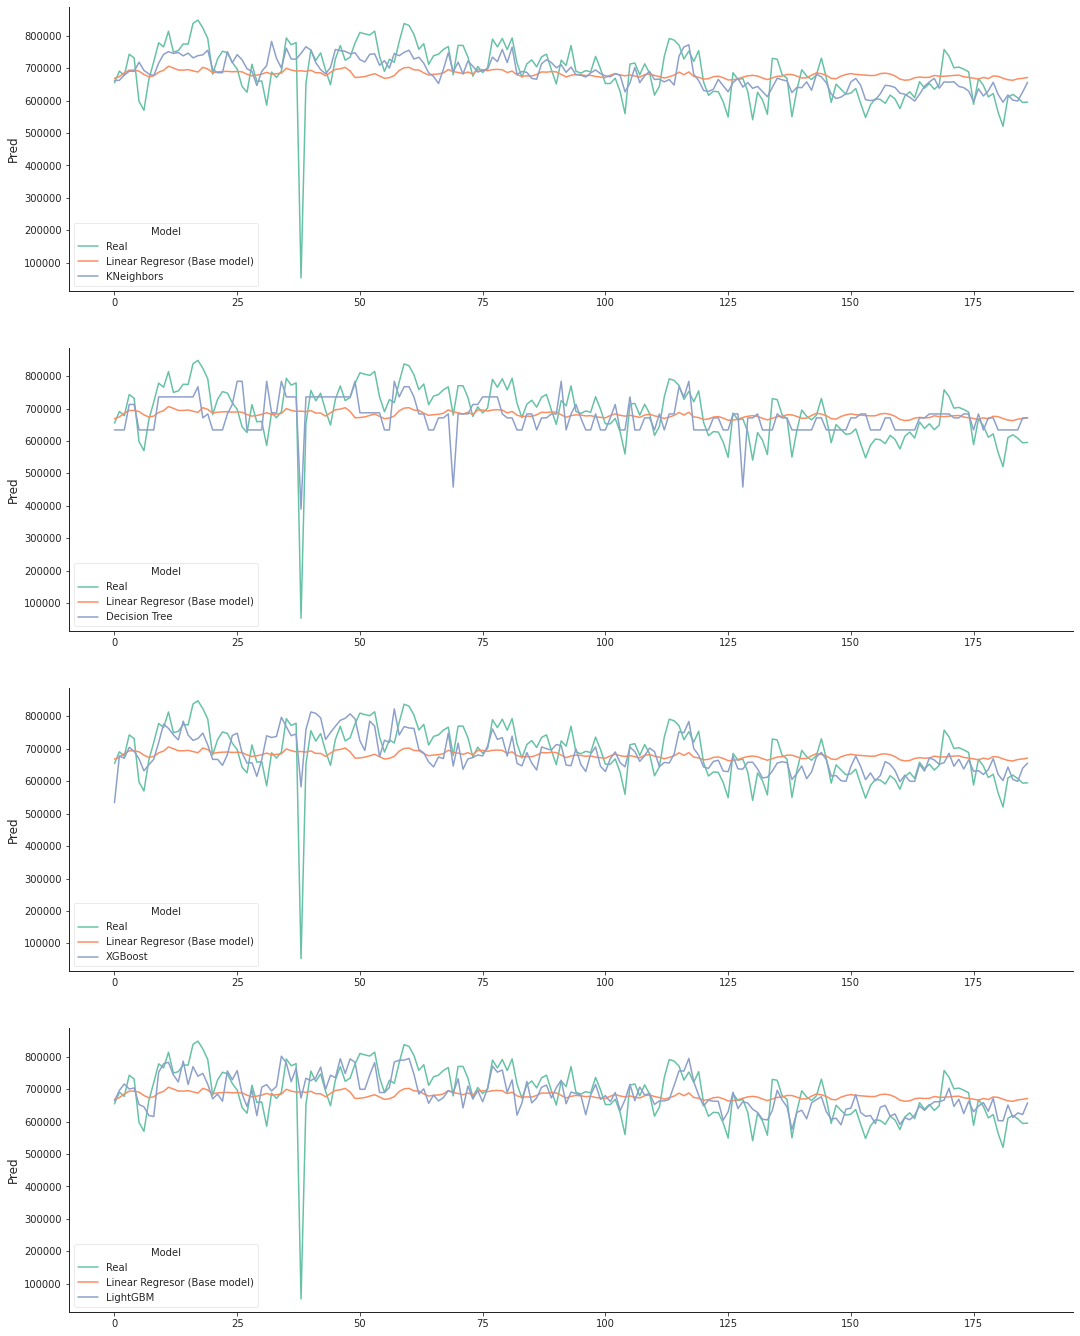

In [23]:
plot_real_vs_pred('x1_peninsular','Generacion_Mwh',X_test,y_test,reg_ln,reg_KN,reg_DT,reg_XGB,reg_LGBM)

# Pipeline

In [26]:
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


ct=ColumnTransformer(
    [
     ('enc',enc_system,['system']),
     ('year',FunctionTransformer(lambda x:np.log(x).str.slice(0,4).astype(int)),['fecha']),
     ('day',FunctionTransformer(lambda x:np.cos(((2*np.pi)/31)*df['fecha'].str.slice(8,10).astype(int))),['fecha']),
     ('month',FunctionTransformer(lambda x:np.cos(((2*np.pi)/12)*x.str.slice(5,7).astype(int))),['fecha']),
     ('weekday',FunctionTransformer(lambda x:np.cos(((2*np.pi)/7)*x.astype(int))),['weekday']),
     ('sc',StandardScaler(),['tmin','presMin','prec','sol','tmax','presMax','racha','velmedia'])
    ]
)

pipe_best_total=make_pipeline(ct,LGBMRegressor(random_state=7))

reg_LGBM=GridSearchCV(pipe_best_total,param_grid=params_LGBM,scoring='neg_mean_squared_error')

reg_LGBM.fit(df_weather_ree[features_list])

joblib.dump(reg_LGBM.best_estimator_, 'best_total_generation.pkl')

# Models for percentaje renovable generation


In [27]:
features_list=['Holiday','weekday','tmin','presMin','prec','sol','tmax','presMax','racha','velmedia','year','day','month','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']
target_list=['x2_Renovable','x1_baleares','x1_canarias','x1_ceuta','x1_melilla','x1_peninsular']

##Train-Test split

In [28]:
X_train,X_test,y_train,y_test,X_validation,y_validacion=train_test_val_split(df_weather_ree,
                                                                        features_list,
                                                                        target_list,
                                                                        .1,
                                                                        0)

##Scaler

In [29]:
from sklearn.preprocessing import StandardScaler

cols_scaler=['tmin','presMin','prec','sol','tmax','presMax','racha','velmedia']
scaler=StandardScaler().fit(X_train[cols_scaler])

X_train[cols_scaler]=scaler.transform(X_train[cols_scaler])
X_test[cols_scaler]=scaler.transform(X_test[cols_scaler])
X_train.head()

,Holiday,weekday,tmin,presMin,prec,sol,tmax,presMax,racha,velmedia,year,day,month,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,1,-0.900969,-1.136261,1.001632,-0.299348,-1.860133,-0.912298,0.989529,0.086529,-0.813986,7.608871,0.979530,0.866025,1.0,0.0,0.0,0.0,0.0
1,1,-0.900969,-0.427684,-1.208123,-0.305329,0.460875,-0.026751,1.022056,-0.660018,-0.508034,7.608871,0.979530,0.866025,0.0,1.0,0.0,0.0,0.0
2,1,-0.900969,-0.011780,1.142394,-0.305329,0.408077,-0.664014,0.693821,-1.603026,-1.305476,7.608871,0.979530,0.866025,0.0,0.0,0.0,1.0,0.0
3,1,-0.900969,-1.056619,-0.697798,1.168923,-1.767660,-1.319413,-1.406834,0.511217,-0.207171,7.608871,0.979530,0.866025,0.0,0.0,0.0,0.0,1.0
4,0,-0.222521,-1.043838,0.945714,-0.305329,-1.479986,-0.614357,0.770705,1.874314,0.750589,7.608871,0.918958,0.866025,1.0,0.0,0.0,0.0,0.0


In [30]:
y_train

,x2_Renovable,x1_baleares,x1_canarias,x1_ceuta,x1_melilla,x1_peninsular
0,0.072795,1.0,0.0,0.0,0.0,0.0
1,0.055826,0.0,1.0,0.0,0.0,0.0
2,0.033501,0.0,0.0,0.0,1.0,0.0
3,0.457916,0.0,0.0,0.0,0.0,1.0
4,0.072290,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
6727,0.414561,0.0,0.0,0.0,0.0,1.0
6728,0.091486,1.0,0.0,0.0,0.0,0.0
6729,0.116369,0.0,1.0,0.0,0.0,0.0
6730,0.038998,0.0,0.0,0.0,1.0,0.0


##Linear Regression

In [31]:
from sklearn.linear_model import LinearRegression


reg_ln=LinearRegression()

reg_ln.fit(X_train,y_train['x2_Renovable'])

y_pred_ln=reg_ln.predict(X_test)


##K-Neighbors

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

reg_KN=GridSearchCV(KNeighborsRegressor(),param_grid={"n_neighbors":np.arange(3,100)},scoring='neg_mean_squared_error')
reg_KN.fit(X_train,y_train['x2_Renovable'])
y_pred_KN=reg_KN.predict(X_test)
reg_KN.best_params_

{'n_neighbors': 17}

## Decision Tree

In [33]:
from sklearn.tree import DecisionTreeRegressor

params_DT={'max_depth':range(3,10),'min_samples_leaf':range(1,3)}

reg_DT=GridSearchCV(DecisionTreeRegressor(random_state=7),param_grid=params_DT,scoring='neg_mean_squared_error')
reg_DT.fit(X_train,y_train['x2_Renovable'])
y_pred_DT=reg_DT.predict(X_test)
reg_DT.best_params_

{'max_depth': 4, 'min_samples_leaf': 1}

##Boosting Models


###XGBoost

In [34]:
from xgboost import XGBRegressor,DMatrix

params_xgb={
    'max_depth':range(3,6),
    'n_estimators':range(50,70,1),
    'learning_rate':np.arange(.1,.14,.005),
    'subsample':np.arange(.7,0.8,0.05)
    }

reg_XGB=GridSearchCV(XGBRegressor(objective='reg:squarederror',random_state=7),param_grid=params_xgb,scoring='neg_mean_squared_error')

reg_XGB.fit(X_train,y_train['x2_Renovable'])
y_pred_XGB=reg_XGB.predict(X_test)

print(reg_XGB.best_params_)
print(reg_XGB.best_estimator_)
print(reg_XGB.best_score_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 55, 'subsample': 0.75}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=55,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.75, verbosity=1)
-0.0019912329603873507


###LightGBM

In [35]:
from lightgbm import LGBMRegressor

params_LGBM={
    'max_depth':range(4,6),
    'n_estimators':range(110,130,1),
    'learning_rate':np.arange(.1,.13,.005),
    'subsample':np.arange(.4,0.6,0.1)
    }

reg_LGBM=GridSearchCV(LGBMRegressor(random_state=7),param_grid=params_LGBM,scoring='neg_mean_squared_error')

reg_LGBM.fit(X_train,y_train['x2_Renovable'])
y_pred_LGBM=reg_LGBM.predict(X_test)

print(reg_LGBM.best_params_)
print(reg_LGBM.best_estimator_)
print(reg_LGBM.best_score_)

{'learning_rate': 0.11000000000000001, 'max_depth': 5, 'n_estimators': 112, 'subsample': 0.4}
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.11000000000000001,
              max_depth=5, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=112, n_jobs=-1, num_leaves=31,
              objective=None, random_state=7, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.4, subsample_for_bin=200000,
              subsample_freq=0)
-0.0019886601600765524


# Evaluation for percentaje renovable generation


## Model choice

,Model_name,MAE,RMSE
0,LinearRegresion (Base Model),0.062381,0.081078
0,KNeighbors,0.050767,0.077128
0,DecissionTree,0.048861,0.072087
0,XGBoost,0.036658,0.053026
0,LightGBM,0.033334,0.048290


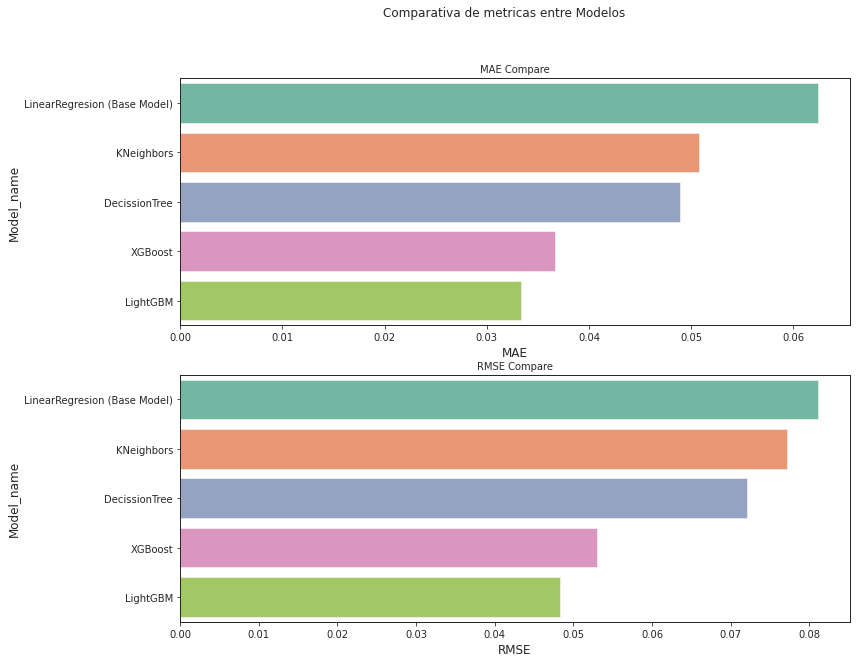

In [36]:
pd_ln=evaluation_function(y_test['x2_Renovable'],y_pred_ln,'LinearRegresion (Base Model)')
pd_kn=evaluation_function(y_test['x2_Renovable'],y_pred_KN,'KNeighbors')
pd_DT=evaluation_function(y_test['x2_Renovable'],y_pred_DT,'DecissionTree')
pd_XGB=evaluation_function(y_test['x2_Renovable'],y_pred_XGB,'XGBoost')
pd_LGBM=evaluation_function(y_test['x2_Renovable'],y_pred_LGBM,'LightGBM')

pd_metrics=pd_ln.append(pd_kn)
pd_metrics=pd_metrics.append(pd_DT)
pd_metrics=pd_metrics.append(pd_XGB)
pd_metrics=pd_metrics.append(pd_LGBM)

plot_metrics(pd_metrics)

pd_metrics

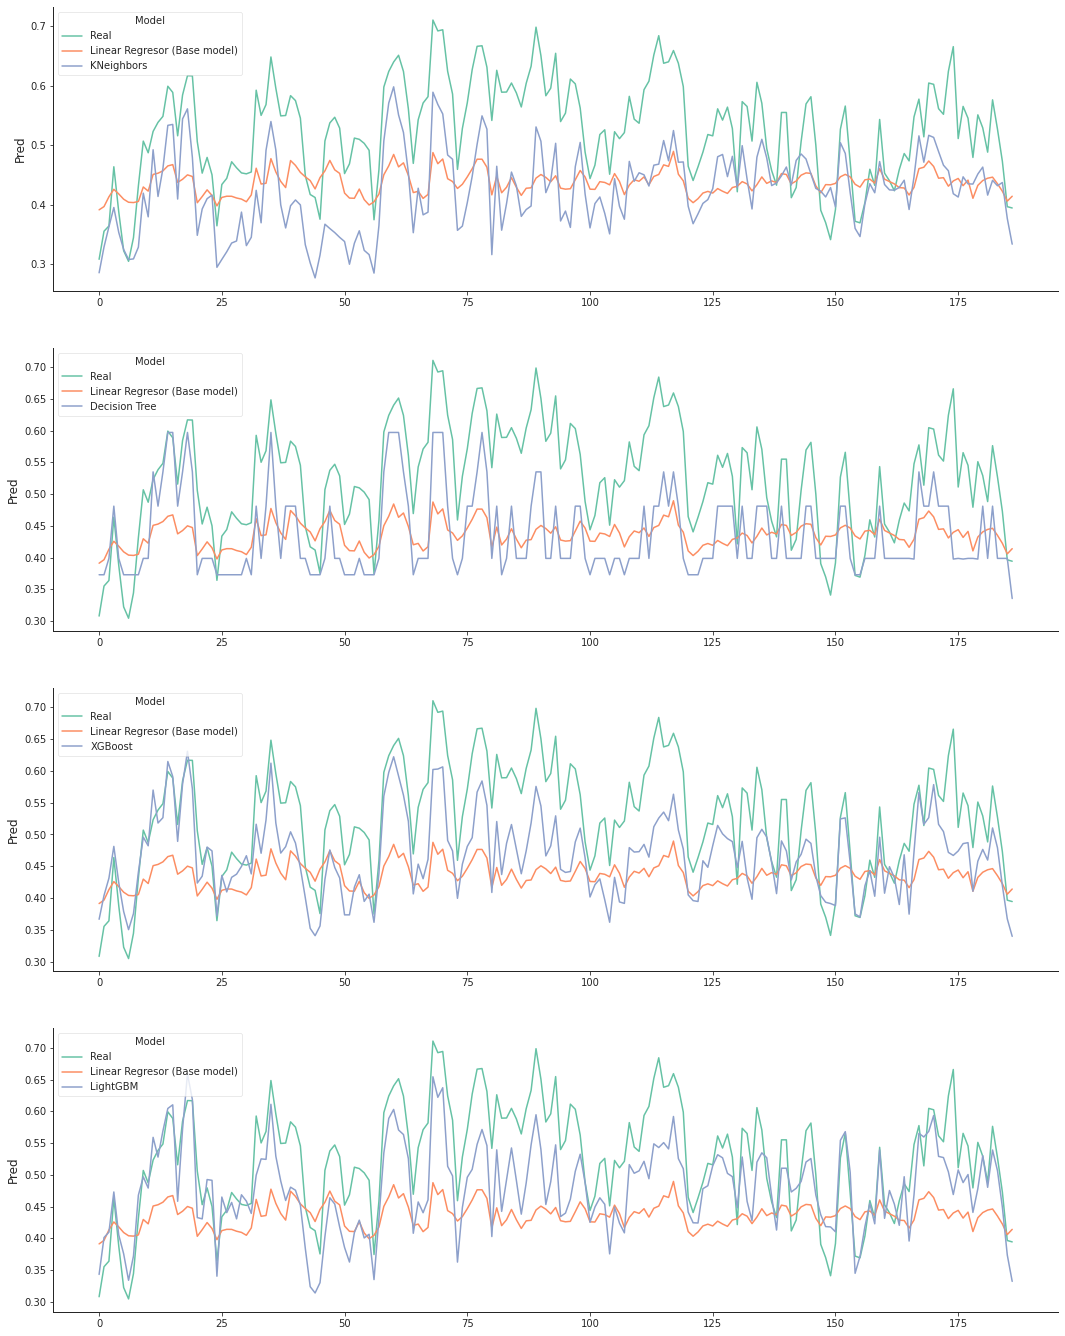

In [37]:
plot_real_vs_pred('x1_peninsular','x2_Renovable',X_test,y_test, reg_ln, reg_KN, reg_DT, reg_XGB, reg_LGBM)